In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from scipy.stats import norm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier # K邻近聚类
from sklearn.tree import DecisionTreeClassifier # 决策树分类
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score,roc_curve, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold,StratifiedShuffleSplit,cross_val_score, cross_val_predict, GridSearchCV
from sklearn.model_selection import train_test_split,ShuffleSplit,learning_curve

import warnings
warnings.filterwarnings("ignore")

In [2]:
"""
sns 相关设置
@return:
"""
# 声明使用 Seaborn 样式
sns.set()
# 有五种seaborn的绘图风格，它们分别是：darkgrid, whitegrid, dark, white, ticks。默认的主题是darkgrid。
sns.set_style("whitegrid")
# 有四个预置的环境，按大小从小到大排列分别为：paper, notebook, talk, poster。其中，notebook是默认的。
sns.set_context('talk')
# 中文字体设置-黑体
plt.rcParams['font.sans-serif'] = ['SimHei']
# 解决保存图像是负号'-'显示为方块的问题
plt.rcParams['axes.unicode_minus'] = False
# 解决Seaborn中文显示问题并调整字体大小
sns.set(font='SimHei')

In [3]:
# reduce_mem_usage 函数通过调整数据类型
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [42]:
data_train = pd.read_excel('train_fea.xlsx')
data_test = pd.read_excel('test_fea.xlsx')

In [29]:
DropFeature = ['service3_level','service1_cnt','service2_cnt']

In [43]:
train_fea = data_train
test_fea = data_test

In [50]:

numerical_fea = list(train_fea.select_dtypes(exclude=['object']).columns)
category_fea = list(filter(lambda x: x not in numerical_fea,list(train_fea.columns)))

In [51]:
#过滤连续型类别特征
def get_numerical_serial_fea(data,feas):
    numerical_serial_fea = []
    numerical_noserial_fea = []
    for fea in feas:
        temp = data[fea].nunique()
        if temp <= 10:# 先以10为分界
            numerical_noserial_fea.append(fea)
            continue
        numerical_serial_fea.append(fea)
    return numerical_serial_fea,numerical_noserial_fea

In [52]:
numerical_serial_fea,numerical_noserial_fea = get_numerical_serial_fea(train_fea,numerical_fea)

In [53]:
numerical_fea.remove('label')
category_fea.remove('user')

In [54]:
# 缺失值填充
train_fea[numerical_fea] = train_fea[numerical_fea].fillna(train_fea[numerical_fea].median())
test_fea[numerical_fea] = test_fea[numerical_fea].fillna(test_fea[numerical_fea].median())


In [57]:

#按照中位数填充数值型特征/或填充0；实验不同的填充方法
train_fea[numerical_fea] = train_fea[numerical_fea].fillna(train_fea[numerical_fea].median())
test_fea[numerical_fea] = test_fea[numerical_fea].fillna(test_fea[numerical_fea].median())
#按照众数填充类别型特征
# data_test_a[category_fea] = data_test_a[category_fea].fillna(train_fea[category_fea].mode())

In [58]:
_2Class = ['sex','verified','agreement1','agreement2','agreement3','agreement4']
_place = ['province','city']
_multiClass = category_fea[11:]+['provider','level','regist_type']

In [59]:
for data in [train_fea, test_fea]:
    for fea in _2Class:
        data[fea] = data[fea].map({'category 0':0,'category 1':1})

In [60]:
from sklearn.preprocessing import LabelEncoder
for col in _multiClass+_place:
    le = LabelEncoder()
    le.fit(list(train_fea[col].astype(str).values) + list(test_fea[col].astype(str).values))
    train_fea[col] = le.transform(list(train_fea[col].astype(str).values))
    test_fea[col] = le.transform(list(test_fea[col].astype(str).values))
print('Label Encoding 完成')

Label Encoding 完成


In [62]:
train_fea.to_csv('train_fea_3.csv',index=None)


In [64]:
test_fea.to_csv('test_fea_3.csv',index=None)

### 数据分箱

In [ ]:
import scipy.stats as spstats
# 从数据分布中移除非零值
income = np.array(fcc_survey_df['Income'])
income_clean = income[~np.isnan(income)]
# 计算最佳λ值
l, opt_lambda = spstats.boxcox(income_clean)
print('Optimal lambda value:', opt_lambda)
 
# 进行Box-Cox变换
fcc_survey_df['Income_boxcox_lambda_opt'] = spstats.boxcox(fcc_survey_df['Income'],lmbda=opt_lambda)


### 特征选择

In [90]:
# train_fea['sex'] = train_fea['sex'].fillna(0) # 使用众数填充?
# test_fea['sex'] = test_fea['sex'].fillna(0)

In [191]:
import toad
from toad.plot import badrate_plot,bin_plot

In [267]:
numerical_fea.remove('age')

In [287]:
data_tr_1 = train_fea
data_ts_1 = test_fea

combiner_1 = toad.transform.Combiner()
combiner_1.fit(data_tr_1,data_tr_1["label"],method='quantile',exclude=["label","user"]+DropFeature)# 等频分箱

bin_tr_1 = combiner_1.transform(data_tr_1) 

<AxesSubplot:xlabel='using_time', ylabel='prop'>

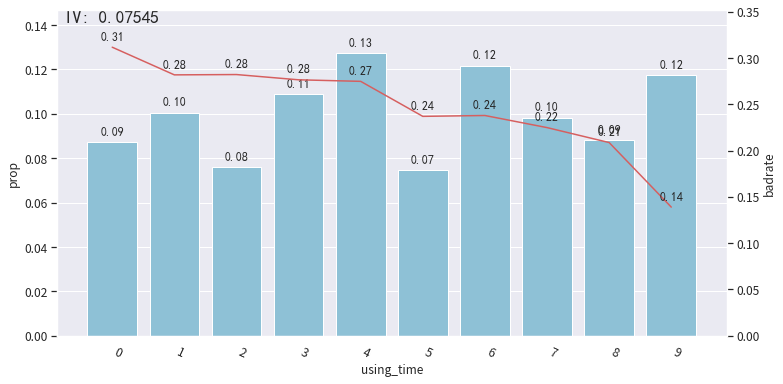

In [307]:
bin_plot(bin_tr_1, x="using_time", target='label')

In [290]:
li = combiner_1.export()
li['using_time'] # 取using_time>=24738的样本作为时间外样本?

[24709.0,
 24712.0,
 24714.0,
 24717.0,
 24722.0,
 24725.0,
 24729.0,
 24733.0,
 24738.0]

In [270]:
transer_1 = toad.transform.WOETransformer()
data_tr_woe_1 = transer_1.fit_transform(bin_tr_1, bin_tr_1["label"],exclude=["label"]+numerical_fea)
data_ts_woe_1 = transer_1.transform(combiner_1.transform(data_ts_1))

In [262]:
# features = [f for f in train_fea.columns if f not in ['user','label']+DropFeature]
# x_train_1 = train_fea[features]
# x_test_1 = test_fea[features]
# y_train = train_fea['label']
# len(numerical_fea)

58

In [271]:
features = [f for f in data_tr_woe_1.columns if f not in ['user','label']+DropFeature]
x_train_1 = data_tr_woe_1[features]
x_test_1 = data_ts_woe_1[features]
y_train = data_tr_woe_1['label']

In [272]:
from xgboost import  plot_importance
class xgBoost(object):
    def __init__(self,datasets,uid,dep,var_names,params,weight,max_del_var_nums=0):
        self.datasets = datasets
        self.x_train = 
        # self.uid = uid
        self.dep = dep # 二分类标签
        self.weight = weight # 考虑与SMOTE过采样相结合来进行？-- 该变量在使用了采样时有用
        self.var_names = var_names
        self.params = params
        self.max_del_var_nums = max_del_var_nums
        self.row_num = 0
        self.col_num = 0

    def training(self,min_score = 0.0001,modelfile="",output_scores=list()):
        lis = self.var_names[:]

        # 将训练集划分为训练集和测试集test_split()实现
        x_train, x_val, y_train, y_val = train_test_split(self.x_train,self.y_train, test_size=0.2)
        # 在外面做好划分以后传进来；
        
        off_data = self.datasets[self.datasets['using_time']>=24738]# 等频分箱结果
        model = xgb.XGBClassifier(
            learning_rate = self.params.get('learning_rate',0.1),
            n_estimators = self.params.get('n_estimators',100),
            max_depth =  self.params.get('max_depth',3),
            min_child_weight =  self.params.get('min_child_weight',1),
            subsample =  self.params.get('subsample',1),
            objective = self.params.get('objective',"binary:logistic"),
            nthread = self.params.get('objective',10),
            scale_pos_weight = self.params.get('scale_pos_weight',1),
            

        )

In [273]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
#GBDT作为基模型的特征选择
selector = SelectFromModel(GradientBoostingClassifier()).fit(x_train_1,y_train)

In [274]:
# from sklearn.feature_selection import chi2
# from sklearn.feature_selection import SelectKBest
# #参数k为选择的特征个数
# from scipy.stats import pearsonr
# #选择K个最好的特征，返回选择特征后的数据
# #第一个参数为计算评估特征是否好的函数，该函数输入特征矩阵和目标向量，
# #输出二元组（评分，P值）的数组，数组第i项为第i个特征的评分和P值。在此定义为计算相关系数
# #参数k为选择的特征个数

# # selector = SelectKBest(k=10).fit(x_train_1,y_train)
# selector = SelectFromModel(LogisticRegression(penalty="l2", C=0.1)).fit(x_train_1,y_train)

In [291]:
from sklearn.model_selection import cross_val_score

"""定义优化函数"""
def rf_cv_lgb(num_leaves, max_depth, bagging_fraction, feature_fraction, bagging_freq, min_data_in_leaf, 
              min_child_weight, min_split_gain, reg_lambda, reg_alpha):
    # 建立模型
    model_lgb = lgb.LGBMClassifier(boosting_type='gbdt', bjective='binary', metric='auc',
                                   learning_rate=0.1, n_estimators=5000,
                                   num_leaves=int(num_leaves), max_depth=int(max_depth), 
                                   bagging_fraction=round(bagging_fraction, 2), feature_fraction=round(feature_fraction, 2),
                                   bagging_freq=int(bagging_freq), min_data_in_leaf=int(min_data_in_leaf),
                                   min_child_weight=min_child_weight, min_split_gain=min_split_gain,
                                   reg_lambda=reg_lambda, reg_alpha=reg_alpha,
                                   n_jobs= 8
                                  )
    
    val = cross_val_score(model_lgb, X_train_split, y_train_split, cv=5, scoring='roc_auc').mean()
    
    return val

In [292]:
from bayes_opt import BayesianOptimization
"""定义优化参数"""
bayes_lgb = BayesianOptimization(
    rf_cv_lgb, 
    {
        'num_leaves':(10, 200),
        'max_depth':(3, 20),
        'bagging_fraction':(0.5, 1.0),
        'feature_fraction':(0.5, 1.0),
        'bagging_freq':(0, 100),
        'min_data_in_leaf':(10,100),
        'min_child_weight':(0, 10),
        'min_split_gain':(0.0, 1.0),
        'reg_alpha':(0.0, 10),
        'reg_lambda':(0.0, 10),
    }
)

"""开始优化"""
bayes_lgb.maximize(n_iter=10)

|   iter    |  target   | baggin... | baggin... | featur... | max_depth | min_ch... | min_da... | min_sp... | num_le... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] Unknown parameter: bjective
[LightGBM] [Warning] feature_fraction is set=0.53, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.53
[LightGBM] [Warning] min_data_in_leaf is set=68, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=68
[LightGBM] [Warning] bagging_fraction is set=0.54, subsample=1.0 will be ignored. Current value: bagging_fraction=0.54
[LightGBM] [Warning] bagging_freq is set=95, subsample_freq=0 will be ignored. Current value: bagging_freq=95
[LightGBM] [Warning] Unknown parameter: bjective
[LightGBM] [Warning] feature_fraction is set=0.53, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.53
[LightG

In [293]:
bayes_lgb.max

{'target': 0.7049855987782164,
 'params': {'bagging_fraction': 0.8988401629290466,
  'bagging_freq': 28.686990517331502,
  'feature_fraction': 0.8229407488304832,
  'max_depth': 10.358006265909081,
  'min_child_weight': 1.0591897727027755,
  'min_data_in_leaf': 41.095273250806535,
  'min_split_gain': 0.6661081870649113,
  'num_leaves': 173.92459293618714,
  'reg_alpha': 4.151846979709591,
  'reg_lambda': 8.956046076928994}}

In [295]:
base_params_lgb = {
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'learning_rate': 0.01,
                    'num_leaves': 173,
                    'max_depth': 10,
                    'min_data_in_leaf': 41,
                    'min_child_weight':1.0,
                    'bagging_fraction': 0.9,
                    'feature_fraction': 0.82,
                    'bagging_freq': 29,
                    'reg_lambda': 9,
                    'reg_alpha': 4,
                    'min_split_gain': 0.7,
                    'nthread': 8,
                    'seed': 2020,
                    'silent': True,
                    'verbose': -1,
}

cv_result_lgb = lgb.cv(
    train_set=train_matrix,
    early_stopping_rounds=1000, 
    num_boost_round=20000,
    nfold=5,
    stratified=True,
    shuffle=True,
    params=base_params_lgb,
    metrics='auc',
    seed=0
)

print('迭代次数{}'.format(len(cv_result_lgb['auc-mean'])))
print('最终模型的AUC为{}'.format(max(cv_result_lgb['auc-mean'])))

迭代次数551
最终模型的AUC为0.7078890841337516


In [275]:
x_train = selector.transform(x_train_1)
x_test = selector.transform(x_test_1)

In [296]:
X_train_split, X_val, y_train_split, y_val = train_test_split(x_train, y_train, test_size=0.2)

train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
valid_matrix = lgb.Dataset(X_val, label=y_val)

params = {
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.01,
            'num_leaves': 173,
            'max_depth': 10,
            'min_data_in_leaf': 41,
            'min_child_weight':1.0,
            'bagging_fraction': 0.9,
            'feature_fraction': 0.82,
            'bagging_freq': 29,
            'reg_lambda': 9,
            'reg_alpha': 4,
            'min_split_gain': 0.7,
            'nthread': 8,
            'seed': 2020,
            'silent': True,
            'verbose': -1,
}

"""使用训练集数据进行模型训练"""
model = lgb.train(params, train_set=train_matrix, valid_sets=valid_matrix, num_boost_round=20000, verbose_eval=1000, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[454]	valid_0's auc: 0.692031


In [277]:
 test_pred = model.predict(x_test, num_iteration=model.best_iteration)

In [299]:
from sklearn.metrics import  confusion_matrix
from sklearn import  metrics
# y_pred = val_pre_lgb

# ROC曲线和AUC
# lr_pres_proba = lr.predict_proba(X_test) [::, 1]
# fpr, tpr, thresholds = roc_curve(y_val, y_pred)
# auc = roc_auc_score(y_val, y_pred)
dev_pre_lgb = model.predict(x_train, num_iteration=model.best_iteration)
val_pre_lgb = model.predict(X_val, num_iteration=model.best_iteration)

fpr_lr_train,tpr_lr_train , _ = roc_curve(y_train,dev_pre_lgb)
train_ks = abs(fpr_lr_train - tpr_lr_train).max()
print("train_ks:",train_ks)
dev_roc_auc = metrics.auc(fpr_lr_train, tpr_lr_train)
fpr_lr_val,tpr_lr_val , _ = roc_curve(y_val,val_pre_lgb)
val_roc_auc = metrics.auc(fpr_lr_val, tpr_lr_val)
from matplotlib import pyplot as plt
plt.plot(fpr_lr_train,tpr_lr_train, label = 'train AUC = %0.4f' % dev_roc_auc)
plt.plot(fpr_lr_val,tpr_lr_val,label = 'val AUC = %0.4f' % val_roc_auc)
# plt.plot([0,1],[0,1],'k--')
plt.plot([0,1],'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc = 'best')
plt.savefig("原始数据lgbROC曲线.png")
plt.show()

AttributeError: 'dict' object has no attribute 'predict'

In [298]:
folds = 5
seed = 2020
kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
cv_scores = []

for i, (train_index, valid_index) in enumerate(kf.split(x_train_1, y_train)):
    print('************************************ {} ************************************'.format(str(i+1)))
    X_train_split, y_train_split, X_val, y_val = x_train_1.iloc[train_index], y_train[train_index], x_train_1.iloc[valid_index], y_train[valid_index]
    
    train_matrix = lgb.Dataset(X_train_split, label=y_train_split)
    valid_matrix = lgb.Dataset(X_val, label=y_val)

    params = {
                # 'boosting_type': 'gbdt',
                # 'objective': 'binary',
                # 'learning_rate': 0.1,
                # 'metric': 'auc',
                # 'min_child_weight': 1e-3,
                # 'num_leaves': 31,
                # 'max_depth': -1,
                # 'reg_lambda': 0,
                # 'reg_alpha': 0,
                # 'feature_fraction': 1,
                # 'bagging_fraction': 1,
                # 'bagging_freq': 0,
                # 'seed': 2020,
                # 'nthread': 8,
                # 'silent': True,
                # 'verbose': -1,
            'boosting_type': 'gbdt',
            'objective': 'binary',
            'metric': 'auc',
            'learning_rate': 0.01,
            'num_leaves': 173,
            'max_depth': 10,
            'min_data_in_leaf': 41,
            'min_child_weight':1.0,
            'bagging_fraction': 0.9,
            'feature_fraction': 0.82,
            'bagging_freq': 29,
            'reg_lambda': 9,
            'reg_alpha': 4,
            'min_split_gain': 0.7,
            'nthread': 8,
            'seed': 2020,
            'silent': True,
            'verbose': -1,
    }
    
    model = lgb.train(params, train_set=train_matrix, num_boost_round=20000, valid_sets=valid_matrix, verbose_eval=1000, early_stopping_rounds=200)
    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    
    cv_scores.append(roc_auc_score(y_val, val_pred))
    print(cv_scores)

print("lgb_scotrainre_list:{}".format(cv_scores))
print("lgb_score_mean:{}".format(np.mean(cv_scores)))
print("lgb_score_std:{}".format(np.std(cv_scores)))

************************************ 1 ************************************
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
[1000]	valid_0's auc: 0.706158
Early stopping, best iteration is:
[867]	valid_0's auc: 0.70627
[0.7062698034099082]
************************************ 2 ************************************
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[400]	valid_0's auc: 0.717644
[0.7062698034099082, 0.7176440300570117]
************************************ 3 ************************************
[LightGBM] [Warning] Unknown parameter: silent
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[493]	valid_0's auc: 0.704644
[0.7062698034099082, 0.7176440300570117, 0.704644007877596]
************************************ 4 ************************************
[LightGBM] [Warning] U